In [125]:
import numpy as np
import sdt.sim
import matplotlib
from matplotlib import pyplot
import tifffile
import io
import h5py, hdf5plugin
import time
import tqdm

from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [42]:
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

In [2]:
def simulate_image(image_size=256, beads=200, sigma=2, amp=500, zrange=12, offset=100, poisson=True):
    coords = np.random.randint(0,image_size, size=(3,beads)).T # z x y
    
    out = np.zeros(
        shape=(image_size,image_size,image_size),
        #dtype=np.uint16
    )
    
    for i in range(image_size):
        filtered_coords = []
        for x in coords:
            if i-(zrange) < x[0] < i+(zrange):
                filtered_coords.append(x)
        
        to_plot = []
        for coord in filtered_coords:
            dz = abs(coord[0] - i)
            #The below ratio is G(x) / G(0) (normalize)
            ratio = np.exp(-1 * (dz**2) / (2 * (sigma**2)))
            to_plot.append( ((coord[1], coord[2]), amp * ratio) )
        
        if len(to_plot) > 0:
            new_coords = np.array( [ [x,y] for ((x,y),_) in to_plot ] )
            new_amplitudes = np.array( [amp for _,amp in to_plot] )

            out[i,...] = sdt.sim.simulate_gauss(
                (image_size,image_size),
                new_coords,
                new_amplitudes,
                np.zeros_like(new_amplitudes)+sigma
            )[...]
    
    out += offset
    
    if poisson:
        return np.random.poisson(lam=out).astype(np.uint16)
    
    return out.astype(np.uint16)

In [3]:
%%timeit
img = simulate_image()

841 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
#tifffile.imwrite('stack.tif', simulate_image(beads=10000))

In [5]:
def test_compression(img, params={}, cs=(32,32,32)):
    with io.BytesIO() as tmpfile:
        with h5py.File(tmpfile, 'w') as h5file:
            #img = simulate_image(beads=beads)
            h5file.create_dataset("data", data=img, **params, chunks=cs)
            return tmpfile.getbuffer().nbytes

In [6]:
def ratio(beads = 200, params={}, bg_sub=0):
    img = simulate_image(beads=beads)
    
    # upsample, bg subtract, then downsample to prevent roundoff errors
    if bg_sub > 0:
        img = img.astype(np.int64)
        img -= bg_sub
        img[ img < 0 ] = 0
        img = img.astype(np.uint16)
        
    start_time = time.time()
    uncompressed = test_compression(img)
    compressed = test_compression(img, params=params)
    return 1.0 * uncompressed / compressed, time.time()-start_time

In [7]:
ratio( params={'compression':'gzip', 'compression_opts':5} )

(2.1367435532416486, 1.593019962310791)

In [8]:
ratio( params=hdf5plugin.Blosc(cname='zstd', clevel=9, shuffle=hdf5plugin.Blosc.BITSHUFFLE) )

(2.580309494012705, 1.9797680377960205)

In [81]:
bead_counts = list( np.logspace(1, 5, num=9).astype(int) )
print(bead_counts)

[10, 31, 100, 316, 1000, 3162, 10000, 31622, 100000]


In [154]:
res = {}
N = 3

algs = [
    ('blosc',hdf5plugin.Blosc(cname='zstd', clevel=9, shuffle=hdf5plugin.Blosc.BITSHUFFLE)),
    ('gzip',{'compression':'gzip', 'compression_opts':5})
]

for algn,algp in tqdm.tqdm(algs):
    res[algn] = {}
    for bcnt in bead_counts:
        res[algn][bcnt] = {}
        for subtract in [True, False]:
            res[algn][bcnt][subtract] = []
            for _ in range(N):
                res[algn][bcnt][subtract].append(
                    ratio(params=algp, beads=bcnt, bg_sub=120 if subtract else 0)[0]
                )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [09:12<00:00, 276.25s/it]


In [150]:
font = {
        'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 8
        }

matplotlib.rc('font', **font)

/var/folders/x9/j3hzs6qj39q6bmxxcjs0ntk00000gn/T/ipykernel_34716/2924122185.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


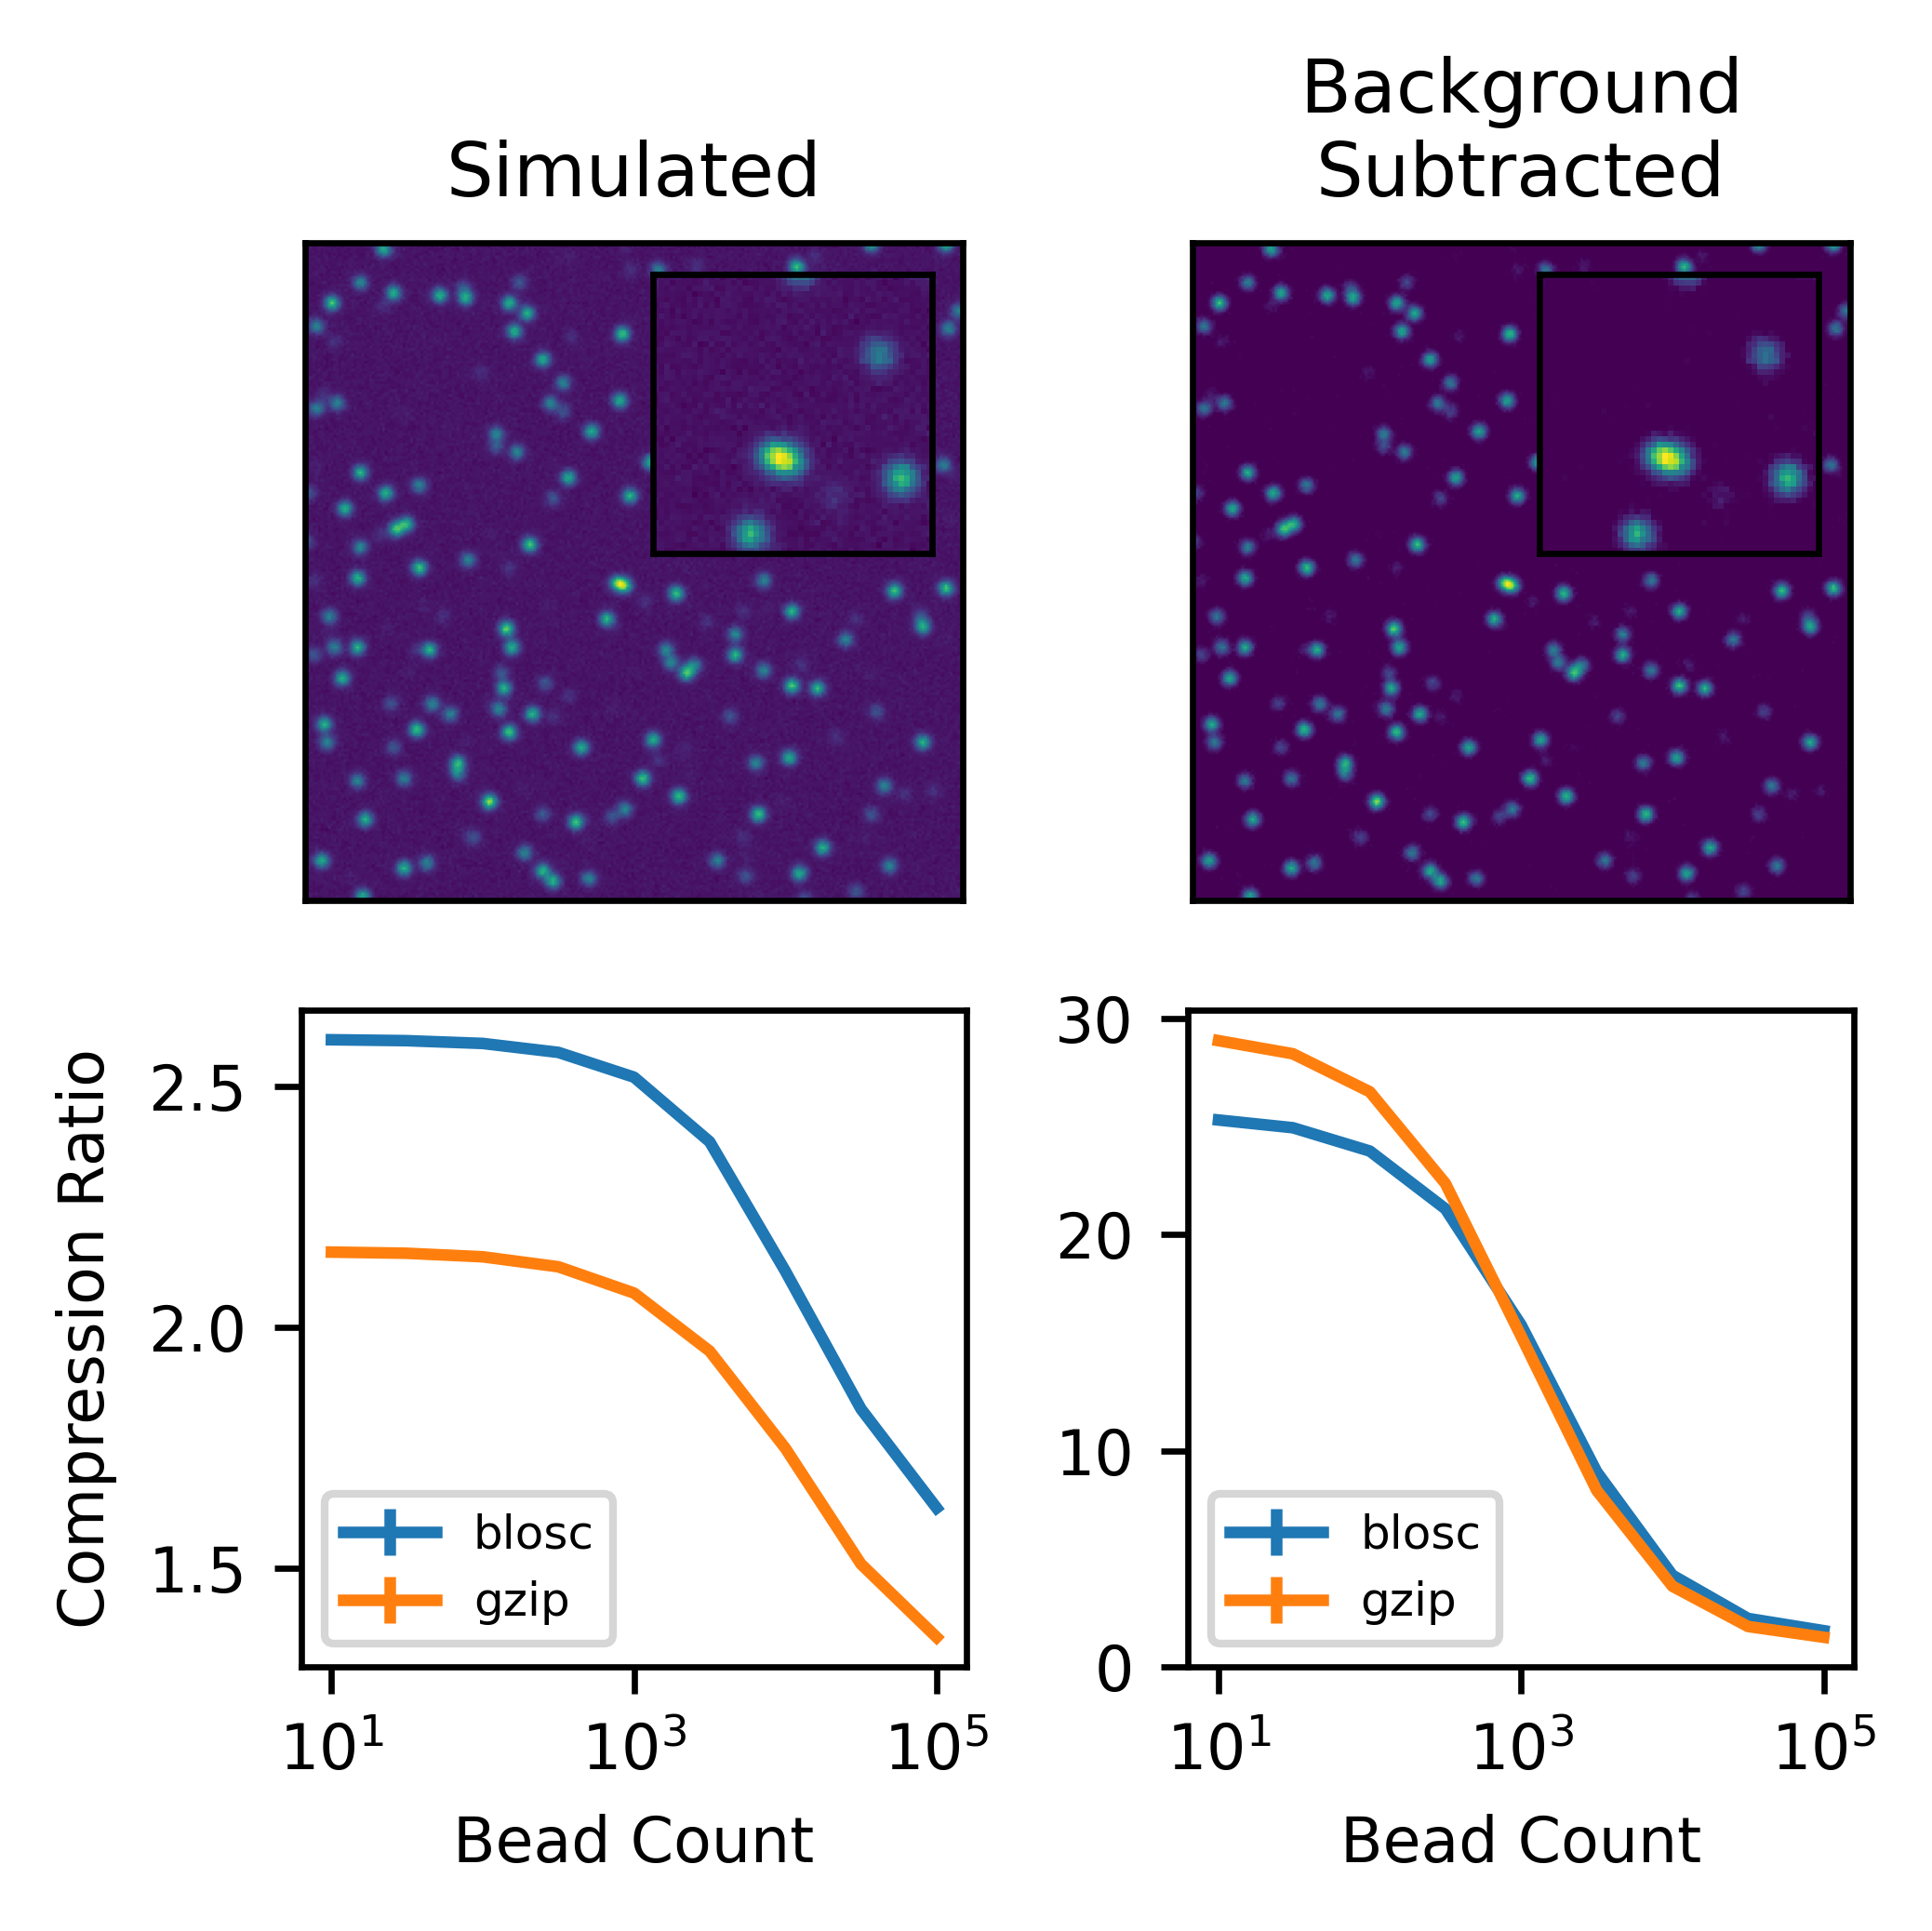

In [161]:
rs = RandomState(MT19937(SeedSequence(123456789)))

fig, axes = pyplot.subplots(2,2,figsize=(3.5,3.5),dpi=600)

img = simulate_image(beads=5000)[128]

axes[0,0].imshow( img )
axes[0,0].set_xticks([], [])
axes[0,0].set_yticks([], [])
axes[0,0].set_title("Simulated")

axins = inset_axes(axes[0,0], width=.5, height=.5, loc=1)
axins.imshow( img[100:, 100:][:50,:50] )
axins.set_xticks([], [])
axins.set_yticks([], [])

#axes[1,0].ticklabel_format(axis='x', style='sci')
for algn,_ in algs:
    axes[1,0].errorbar(
        bead_counts,
        [np.mean(res[algn][bcnt][False]) for bcnt in bead_counts],
        yerr=[np.std(res[algn][bcnt][False]) for bcnt in bead_counts],
        label=algn
    )
#xes[1,0].set_yscale('log')
axes[1,0].set_xscale('log')
axes[1,0].set_xticks([10**1, 10**3, 10**5])
#axes[1,0].set_ylim(1,10)
axes[1,0].legend(loc=3, fontsize=6)
axes[1,0].set_xlabel('Bead Count')
axes[1,0].set_ylabel('Compression Ratio')

img = img.astype(np.int64) - 120
img[ img < 0 ] = 0
img = img.astype(np.uint16)

axes[0,1].imshow( img )
axes[0,1].set_xticks([], [])
axes[0,1].set_yticks([], [])
axes[0,1].set_title("Background\nSubtracted")

axins = inset_axes(axes[0,1], width=.5, height=.5, loc=1)
axins.imshow( img[100:, 100:][:50,:50] )
axins.set_xticks([], [])
axins.set_yticks([], [])

for algn,_ in algs:
    axes[1,1].errorbar(
        bead_counts,
        [np.mean(res[algn][bcnt][True]) for bcnt in bead_counts],
        yerr=[np.std(res[algn][bcnt][True]) for bcnt in bead_counts],
        label=algn
    )
#axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].set_xticks([10**1, 10**3, 10**5])
axes[1,1].set_xlabel('Bead Count')
axes[1,1].legend(loc=3, fontsize=6)

fig.tight_layout()
fig.savefig('simfig.pdf')